In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yfin
yfin.pdr_override()
import random as rand
from sklearn.model_selection import train_test_split
import datetime

In [2]:
def monte_carlo_sim(data, testsize = 0.5, simulation = 100):    
    
    df, test = train_test_split(data, test_size = testsize, shuffle = False)
    days_forecast = len(test)
    df = df.loc[:, ['Adj Close']]
    # here we use log return
    log_return = np.log(1 + df['Adj Close'].pct_change())
    variance = log_return.var()
    mu = log_return.mean()
    std_dev = log_return.std()
    drift = mu - variance / 2
    
    # we use dictionary to store predicted time series
    ts_data = {}
    for counter in range(simulation):
        ts_data[counter] = [df['Adj Close'].iloc[0]]
        # we need to compare the forecast with the historical data as well
        for i in range(len(df) + days_forecast - 1):
            sde = drift + std_dev * rand.gauss(0,1)
            temp = ts_data[counter][-1] * np.exp(sde)
            #returns = np.exp(drift + std_dev * norm.ppf(np.random.rand()))
            ts_data[counter].append(temp.item())
    
    # this is done to compare every simulation with actual data in terms of std_dev
    std = float('inf')
    pick = 0
    for counter in range(simulation):
        temp = np.std(np.subtract(ts_data[counter][:len(df)], df['Adj Close']))
        if temp < std:
            std = temp
            pick = counter
    
    return days_forecast, ts_data, pick

In [3]:
# this function plots the MCS values 
def plot_mcs(df, days_forecast, ts_data, pick, ticker):
    ax = plt.figure(figsize = (12, 5)).add_subplot(111)
    node = len(df) - days_forecast
    for i in range(int(len(ts_data))):
        if i != pick:
            ax.plot(df.index[:node], ts_data[i][:node], alpha = 0.5)

    ax.plot(df.index[:node], ts_data[pick][:node], color = 'green', linewidth = 5, label = 'Best Fitting Curve')
    df['Adj Close'].iloc[:node].plot(color = 'red', linewidth = 5, label = 'Actual')
    # plt.plot(df['Adj Close'], linewidth = 5,label = 'Actual')
    plt.title(f'Monte Carlo Simulation\nTicker: {ticker}')
    plt.legend(loc = 'upper left')
    plt.ylabel('Price (INR)')
    plt.xlabel('Date')
    plt.show()
        
    # this second figure plots both training and testing data and compares the best fitted curve
    ax = plt.figure(figsize = (12, 5)).add_subplot(111)
    plt.plot(ts_data[pick], label = 'Best Fitting Curve', color = 'blue')
    plt.plot(df['Adj Close'].tolist(), label = 'Actual', color='black')
    plt.axvline(node, linestyle = '--', color = 'black')
    plt.text(node - 50, max(max(df['Adj Close']), max(ts_data[pick])), 'Training', horizontalalignment = 'center', verticalalignment = 'center')
    plt.text(node + 50, max(max(df['Adj Close']), max(ts_data[pick])), 'Testing', horizontalalignment = 'center', verticalalignment = 'center')
    plt.title(f'Training versus Testing\nTicker: {ticker}\n')
    plt.legend(loc = 'upper left')
    plt.ylabel('Price (INR)')
    plt.xlabel('T+Days')
    plt.show()

[*********************100%%**********************]  1 of 1 completed


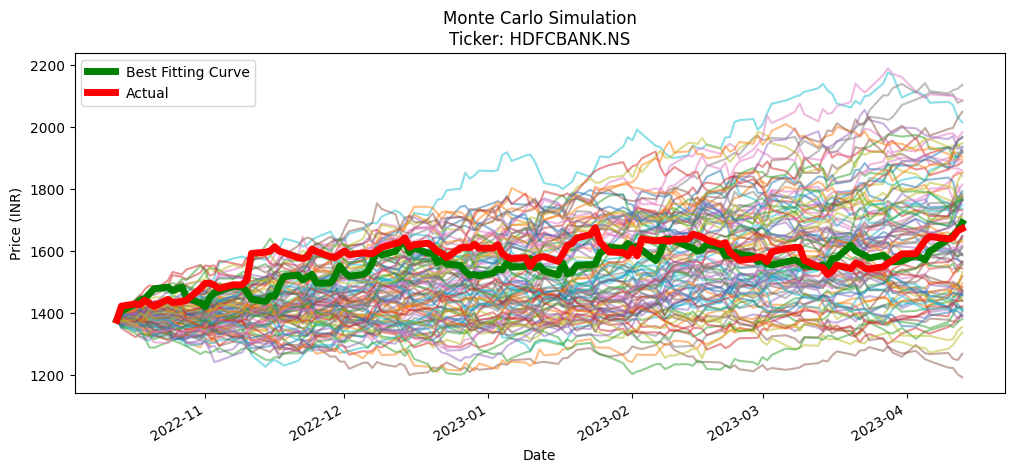

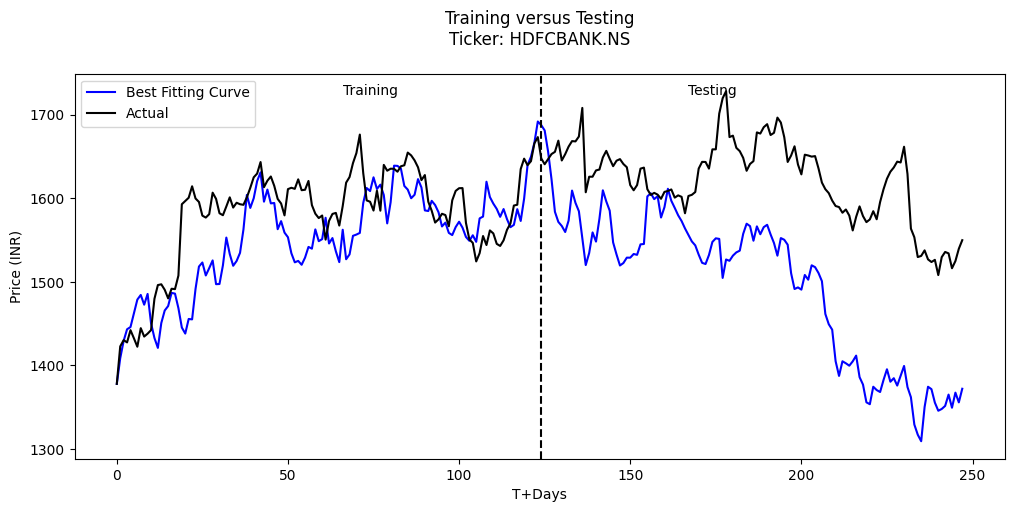

In [4]:
def main():
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(365)
    ticker = 'HDFCBANK.NS'

    df = yfin.download(ticker, start = start_date, end = end_date)
    df.index = pd.to_datetime(df.index)
    
    days_forecast, ts_data, pick = monte_carlo_sim(df)
    plot_mcs(df, days_forecast, ts_data, pick, ticker)

if __name__ == '__main__':
    main()